$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$
$$
u(x,0) = f(x) = e^{-x^2}, \quad x \in [-5,5]
$$

$$
u(-5,t) = g_1(t), \quad u(5,t) = g_2(t), \quad t \geq 0
$$

In [1]:
# =============
# CARGA DE LIBRERIAS

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftfreq

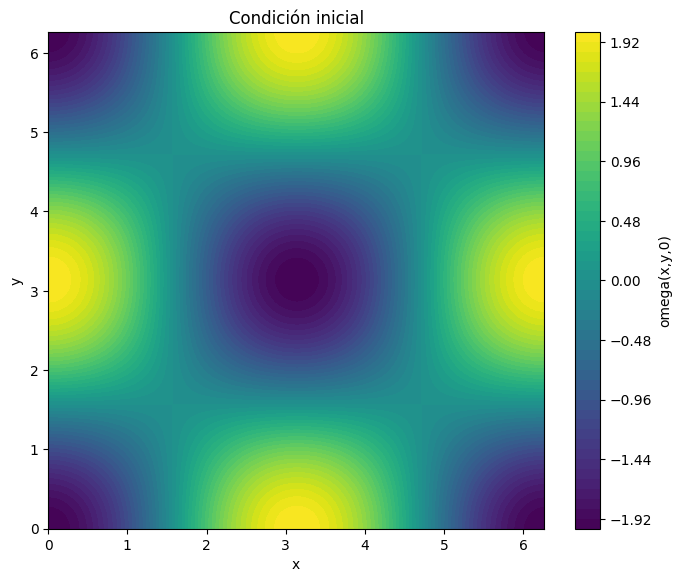

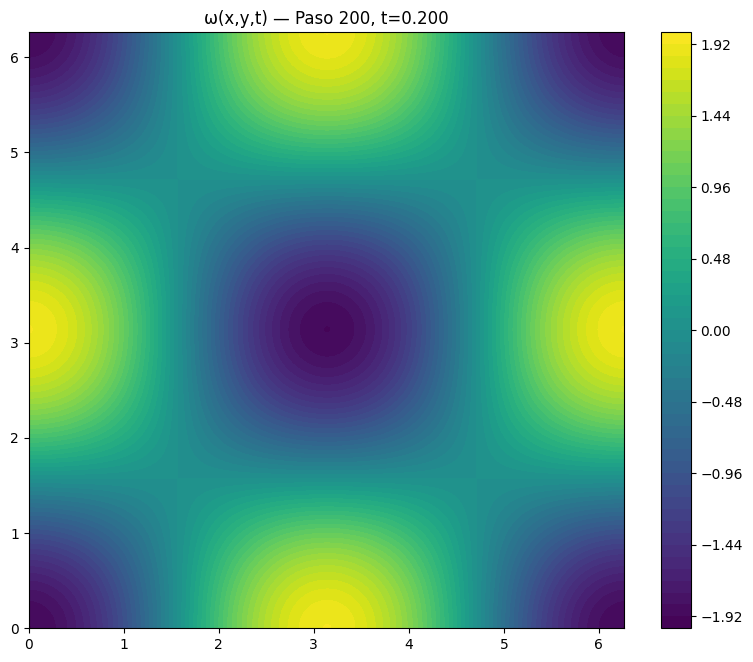

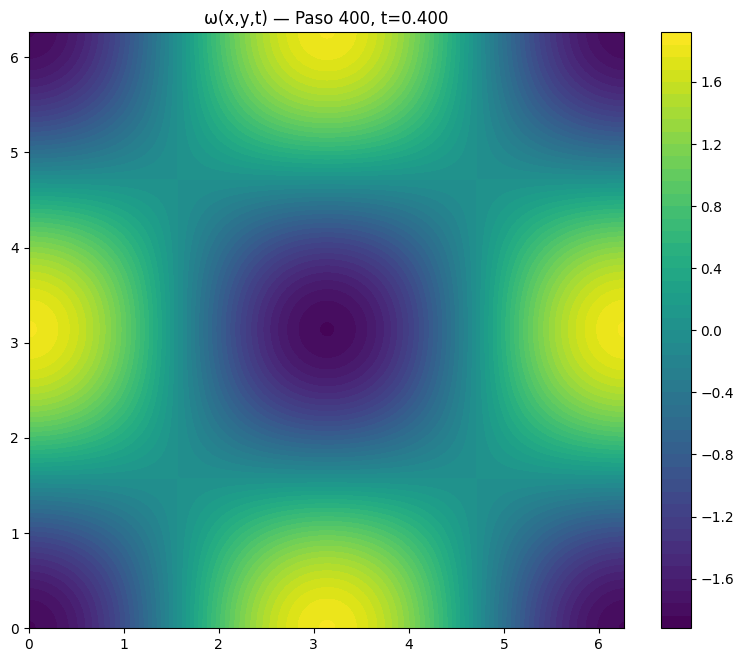

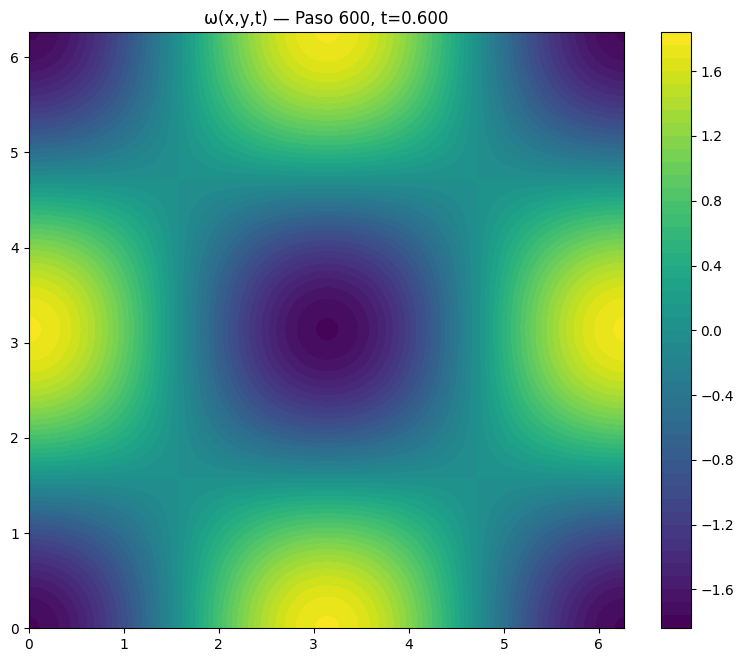

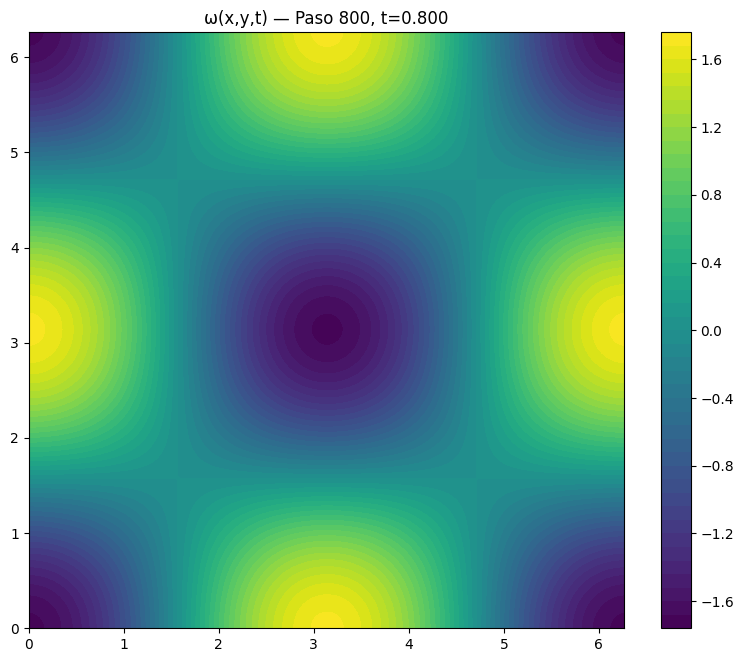

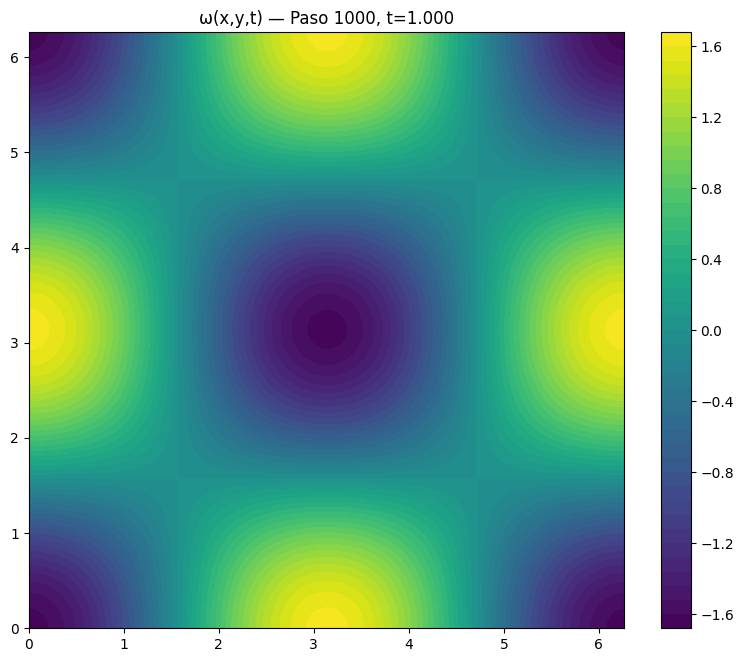

In [2]:
# RESOLUCION MEDIANTE MDF

# Parametros
Nx, Ny = 300, 300
Lx, Ly = 2*np.pi, 2*np.pi
dx, dy = Lx/Nx, Ly/Ny
x = np.linspace(0, Lx, Nx, endpoint=False)
y = np.linspace(0, Ly, Ny, endpoint=False)
X, Y = np.meshgrid(x, y, indexing='ij')

# Condicion inicial
omega = -2 * np.cos(X) * np.cos(Y)

# FFT - para Poisson
kx = fftfreq(Nx, d=dx) * 2*np.pi
ky = fftfreq(Ny, d=dy) * 2*np.pi
KX, KY = np.meshgrid(kx, ky, indexing='ij')
K2 = KX**2 + KY**2
K2[0, 0] = 1  # para evitar división por cero

# Paso temporal
nu = 0.1
dt = min(dx, dy)**2 / (4*nu)  # estabilidad de difusion
dt = 0.001
TMAX = 1.0
Nt = int(TMAX / dt)

# Derivadas centradas
def gradx(f):
    return (np.roll(f, -1, axis=0) - np.roll(f, 1, axis=0)) / (2*dx)

def grady(f):
    return (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1)) / (2*dy)

def laplacian(f):
    return (
        (np.roll(f, -1, axis=0) - 2*f + np.roll(f, 1, axis=0)) / dx**2 +
        (np.roll(f, -1, axis=1) - 2*f + np.roll(f, 1, axis=1)) / dy**2
    )

# Funcion para resolver ∇²ψ = -ω usando FFT
def poisson_solve(omega):
    omega_hat = fft2(omega)
    psi_hat = -omega_hat / K2
    psi_hat[0, 0] = 0  # para evitar modo constante indefinido
    return np.real(ifft2(psi_hat))

# Visualizacion inicial
plt.figure(figsize=(8, 6.45))
plt.contourf(X, Y, omega, levels=50, cmap='viridis')
plt.colorbar(label='omega(x,y,0)')
plt.title('Condición inicial')
plt.xlabel('x'); plt.ylabel('y')
plt.axis('equal')
plt.show()

# Simulacion en el tiempo
for step in range(Nt):
    psi = poisson_solve(omega)
    u = -grady(psi)
    v = gradx(psi)

    convection = u * gradx(omega) + v * grady(omega)
    diffusion = nu * laplacian(omega)
    domega_dt = -convection + diffusion
    omega += dt * domega_dt

    # Mostrar algunas graficas intermedias
    if (step+1) % (Nt // 5) == 0:
        plt.figure(figsize=(8*1.2, 6.45*1.2))
        plt.clf()
        plt.contourf(X, Y, omega, levels=50, cmap='viridis')
        plt.title(f'ω(x,y,t) — Paso {step+1}, t={(step+1)*dt:.3f}')
        plt.colorbar()
        plt.pause(0.01)

plt.show()